Malicious or Benign Websites Technical Machine Learning Notebook

Chris Heimbuch

In [ ]:
a

The analysis of the EDA performed revealed some interesting things. After performing my inferential analysis, it was found that there was a statistically significant difference in means between DNS packets generated between the honeypot and server for both benign and malicious websites. It was also found that TCP packets exchangeds for different malicious website servers, such as Apache, Nginx, and "other", were found to have statistically significant difference as we rejected our null hypothesis stating that the means were equal between all groups. I expect these features, 'tcp_conversion_exchange', 'dns_query_times' to have some importance for our modeling. Also, seeing as how Spain hosted the most malicious websites, I expect this to have some correlation with malicious websites. We will be using the 'type' column for predictions. 1 represents a malicious website and 0 represents a benign website. Some preprocessing techniques I believe I will need to employ off the bat will be an encoding technique to encode a few features for machine learning. I don't think encoding that date columns is a good idea because of how unique each of them are. They would produce thousands of extra features, which would potentially lead to "curse of dimensionality", and there is simply not enough data for any meaningful learning. Let's get started!

In [1]:
# Standard DS imports
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Machine learning imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, explained_variance_score, r2_score, mean_absolute_error
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

# Machine Learning Algorithms
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, ExtraTreesRegressor

#data balancing
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

### For this notebook, I am going to bring in all the cleaning I did in my other notebook, but I will further preprocess the data and clean up columns for machine learning!

In [2]:
# Call in dataset and inspect the head.
df = pd.read_csv("dataset.csv")

In [3]:
#Going to create a copy of the df to work with.
df_copy = df.copy()

In [4]:
#Make all columns lowercase
df_copy.columns = df_copy.columns.str.lower()

In [5]:
#Clean up the 'charset' column: replace the dashes with spaces and make it Title case
df_copy['charset'] = df_copy['charset'].str.replace('-', ' ')
df_copy['charset'] = df_copy['charset'].str.title()

In [6]:
#Going to perform null value imputation with KNN imputation method.

#Encode only the known values.
le = LabelEncoder()
df_copy['charset_encoded'] = df_copy['charset']
df_copy.loc[df_copy['charset'].notnull(), 'charset_encoded'] = le.fit_transform(df_copy['charset'].dropna())

#Apply KNN imputation on the encoded column.
imputer = KNNImputer(n_neighbors=3)
df_copy['charset_encoded'] = imputer.fit_transform(df_copy[['charset_encoded']])

#Inverse transform the encoded data back to the original categories.
df_copy['charset_imputed'] = df_copy['charset_encoded'].round().astype(int)
df_copy['charset_imputed'] = le.inverse_transform(df_copy['charset_imputed'])

#Compare the original and imputed columns to verify our imputation has succeeded.
imputed_values = df_copy[df_copy['charset'].isnull()]

print(imputed_values[['charset', 'charset_imputed']])

     charset charset_imputed
35       NaN        Us Ascii
81       NaN        Us Ascii
125      NaN        Us Ascii
159      NaN        Us Ascii
952      NaN        Us Ascii
977      NaN        Us Ascii
1069     NaN        Us Ascii


In [7]:
#Dropping as no longer needed.
df_copy = df_copy.drop(columns=["charset_encoded", "charset"])

In [8]:
#Fill in nulls with unknown.
df_copy['server'].fillna("Unknown", inplace=True)

In [9]:
#Clean up the 'charset' column: replace the dashes with spaces and make it Title case
df_copy['server'] = df_copy['server'].str.lower()

In [10]:
#Grouping values with the least count into one bin "Other" to reduce number of unique values
series = pd.value_counts(df_copy.server)
mask = (series/series.sum() * 100).lt(1)
df_copy['server'] = np.where(df_copy['server'].isin(series[mask].index),'other',df_copy['server'])

In [11]:
 # Further bucketing and cleaning up the server column.

def standardize_server(server_string):
    if 'apache' in server_string:
        return 'apache'
    if 'nginx' in server_string:
        return 'nginx'
    if 'microsoft' in server_string:
        return 'microsoft-IIS'

    return server_string

#Applying function.
df_copy['standardized_server'] = df_copy['server'].apply(standardize_server)
df_copy['standardized_server'] = df_copy['standardized_server'].str.replace('-', ' ')

print(df_copy[['server', 'standardized_server']])

                     server standardized_server
0                     nginx               nginx
1                     other               other
2     microsoft-httpapi/2.0       microsoft IIS
3                     nginx               nginx
4                   unknown             unknown
...                     ...                 ...
1776                 apache              apache
1777                 apache              apache
1778                  other               other
1779       cloudflare-nginx               nginx
1780                  other               other

[1781 rows x 2 columns]


In [12]:
#Interpolate content length column
df_copy['content_length'] = df_copy['content_length'].interpolate()

In [13]:
#Function to replace the strange values in the column.
def replace(x):
    if x == "[u'GB'; u'UK']"or x=="United Kingdom" or x=="UK":
        return "GB"
    elif x == "Cyprus":
        return "CY"
    elif x == "us":
        return "US"
    elif x == "ru":
        return "RU"
    elif x == "se":
        return "SE"
    else:
        return x
    
df_copy["whois_country"] = list(map(lambda x: replace(x), df_copy["whois_country"]))

In [14]:
#Filling the NA as 'other' category.
df_copy['whois_country'].fillna("Other", inplace=True)

In [15]:
#Cleaning up data and nulls.
def replace_state(x):
    if x == "California"or x=="CALIFORNIA":
        return "CA"
    elif x == "Arizona":
        return "AZ"
    elif x == "New York" or x=="NEW YORK":
        return "NY"
    elif x == "Ohio":
        return "OH"
    elif x == "Utah":
        return "UT"
    elif x == "None":
        return "NA"
    elif x == "Texas":
        return "TX"
    elif x == "Washington":
        return "WA"
    elif x == "va":
        return "VA"
    elif x == "Illinois" or x=="il":
        return "IL"
    elif x == "District of Columbia" or x=="DC" or x=="Maryland":
        return "MD"
    elif x == "New Jersey":
        return "NJ"
    elif x == "Maine" or x=="MAINE":
        return "ME"
    elif x == "Quebec" or x=="QUEBEC" or x=="qc" or x=="quebec":
        return "QC"
    elif x == "Missouri":
        return "MO"
    elif x == "Nevada":
        return "NV"
    elif x == "WC1N" or x=="Greater London" or x=="UK" or x=="WEST MIDLANDS" or x=="worcs" or x=="Peterborough" or x=="London" or x=="HANTS" or x=="MIDDLESEX":
        return "England"
    elif x == "Pennsylvania":
        return "PA"
    elif x == "Florida" or x=="FLORIDA":
        return "FL"
    elif x == "PANAMA":
        return "Panama"
    else:
        return x
    
df_copy["whois_statepro"] = list(map(lambda x: replace_state(x), df_copy["whois_statepro"]))

In [16]:
#Grouping values with the least count into one bin "Other" to reduce number of unique values
counts = df_copy['whois_statepro'].value_counts()
df_copy['whois_statepro'] = np.where(df_copy['whois_statepro'].isin(counts[counts < 15].index),'Other',df_copy['whois_statepro'])

In [17]:
#Fill null's with "Other".
df_copy['whois_statepro'].fillna("Other", inplace=True)

In [18]:
#Going to look at the dates now and clean up the format on those.

#Make function to clean up data column.
def date_cleaner(datetime_str):
    if datetime_str in [np.nan, "b", "0", "None"]:  # these are the missing values and a random b thrown in the mix.
        return np.nan
    
    if "T" in datetime_str:
        split_datetime = datetime_str.split("T")
    else:
        split_datetime = datetime_str.split()
    
    date = split_datetime[0]
    date_with_slash = date.replace("-", "/")
    
    if date_with_slash == "2002/03/20":  # only one instance of this.
        date_with_slash = "20/03/2002"
    return date_with_slash

In [19]:
#Going to apply the cleaner format to both regdate and updated date columns
df_copy.whois_regdate = df_copy.whois_regdate.apply(date_cleaner)
df_copy["whois_regdate"] = pd.to_datetime(df_copy.whois_regdate, format="%d/%m/%Y", errors="coerce")

#Update the updated_date column
df_copy.whois_updated_date = df_copy.whois_updated_date.apply(date_cleaner)
df_copy["whois_updated_date"] = pd.to_datetime(df_copy.whois_updated_date, format="%d/%m/%Y", errors="coerce")

#Filling null values with the median. The reason being is it is impossible to know what these dates could be. The median offers the most common date which could help with our analysis.
df_copy["whois_regdate"].fillna(df_copy["whois_regdate"].median(), inplace=True)
df_copy["whois_updated_date"].fillna(df_copy["whois_updated_date"].median(), inplace=True)

In [20]:
#I will interpolate the dns query column. It's one value, so filling in the null value with a linear approach should work.
df_copy['dns_query_times'] = df_copy['dns_query_times'].interpolate()

In [21]:
#Change column to int type for cleaner clarity.
df_copy['dns_query_times'] = df_copy['dns_query_times'].astype(int) 

In [22]:
#Drop the server column since we have it standardized and ready to go.
df_copy = df_copy.drop(columns=["server"])

In [23]:
df_copy

,url,url_length,number_special_characters,content_length,whois_country,whois_statepro,whois_regdate,whois_updated_date,tcp_conversation_exchange,dist_remote_tcp_port,...,app_bytes,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,app_packets,dns_query_times,type,charset_imputed,standardized_server
0,M0_109,16,7,263.0,Other,Other,2015-10-10,2016-08-23,7,0,...,700,9,10,1153,832,9,2,1,Iso 8859 1,nginx
1,B0_2314,16,6,15087.0,Other,Other,2001-01-16,2016-08-23,17,7,...,1230,17,19,1265,1230,17,0,0,Utf 8,other
2,B0_911,16,6,324.0,Other,Other,2001-01-16,2016-08-23,0,0,...,0,0,0,0,0,0,0,0,Us Ascii,microsoft IIS
3,B0_113,17,6,162.0,US,Other,1997-10-07,2013-09-12,31,22,...,3812,39,37,18784,4380,39,8,0,Iso 8859 1,nginx
4,B0_403,17,6,124140.0,US,TX,1996-05-12,2017-04-11,57,2,...,4278,61,62,129889,4586,61,4,0,Utf 8,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,M4_48,194,16,6897.0,ES,Barcelona,2008-09-17,2016-09-02,0,0,...,0,0,3,186,0,0,0,1,Utf 8,apache
1777,M4_41,198,17,7900.5,ES,Barcelona,2008-09-17,2016-09-02,0,0,...,0,0,2,124,0,0,0,1,Utf 8,apache
1778,B0_162,201,34,8904.0,US,FL,1999-02-15,2015-07-15,83,2,...,6631,87,89,132181,6945,87,4,0,Utf 8,other
1779,B0_1152,234,34,16669.5,US,CA,1998-04-01,2016-12-09,0,0,...,0,0,0,0,0,0,0,0,Iso 8859 1,nginx


### The URL is encoded in a unique way and they are all unique urls in the data set. It won't be helpful for us in our analysis by revealing any sort of importance or prediction, therefore I will drop that column. I will try encoding certain categorical columns.

In [24]:
#Creating a DF for preprocessing.
preprocess_df = df_copy.copy()

In [25]:
#Dropping url and the date columns. Too many unique dates and may not offer any signal.
preprocess_df.drop(columns=["url", "whois_regdate", "whois_updated_date"], inplace=True)


In [26]:
#Instantiating the one hot encoder.
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [27]:
#Creating variable to encode the columns I wish to encode.
columns_to_encode = ['whois_country', 'whois_statepro', 'charset_imputed', 'standardized_server']


In [28]:
#Fit and transforming the columns
encoded_data = encoder.fit_transform(preprocess_df[columns_to_encode])

In [29]:
#Getting the feature names out of the encoder by passing in the columns we originally wanted to encode.
feature_names = encoder.get_feature_names_out(columns_to_encode)

In [30]:
#Creating a dataframe on the encoded data.
encoded_df = pd.DataFrame(encoded_data, columns=feature_names)
encoded_df

,whois_country_AE,whois_country_AT,whois_country_AU,whois_country_BE,whois_country_BR,whois_country_BS,whois_country_BY,whois_country_CA,whois_country_CH,whois_country_CN,...,charset_imputed_Windows 1252,standardized_server_apache,standardized_server_ats,standardized_server_gse,standardized_server_microsoft IIS,standardized_server_nginx,standardized_server_other,standardized_server_server,standardized_server_unknown,standardized_server_youtubefrontend
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [31]:
#Adding the new columns I just encoded to the preprocessed dataframe. I am dropping the columns that were not encoded as they are no longer required. 
preprocess_df = pd.concat([preprocess_df.drop(columns=columns_to_encode), encoded_df], axis=1)

In [32]:
#Sanity check and inspection of the dateframe. Success.
preprocess_df

,url_length,number_special_characters,content_length,tcp_conversation_exchange,dist_remote_tcp_port,remote_ips,app_bytes,source_app_packets,remote_app_packets,source_app_bytes,...,charset_imputed_Windows 1252,standardized_server_apache,standardized_server_ats,standardized_server_gse,standardized_server_microsoft IIS,standardized_server_nginx,standardized_server_other,standardized_server_server,standardized_server_unknown,standardized_server_youtubefrontend
0,16,7,263.0,7,0,2,700,9,10,1153,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,16,6,15087.0,17,7,4,1230,17,19,1265,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,16,6,324.0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,17,6,162.0,31,22,3,3812,39,37,18784,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,17,6,124140.0,57,2,5,4278,61,62,129889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,194,16,6897.0,0,0,0,0,0,3,186,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1777,198,17,7900.5,0,0,0,0,0,2,124,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1778,201,34,8904.0,83,2,6,6631,87,89,132181,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1779,234,34,16669.5,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


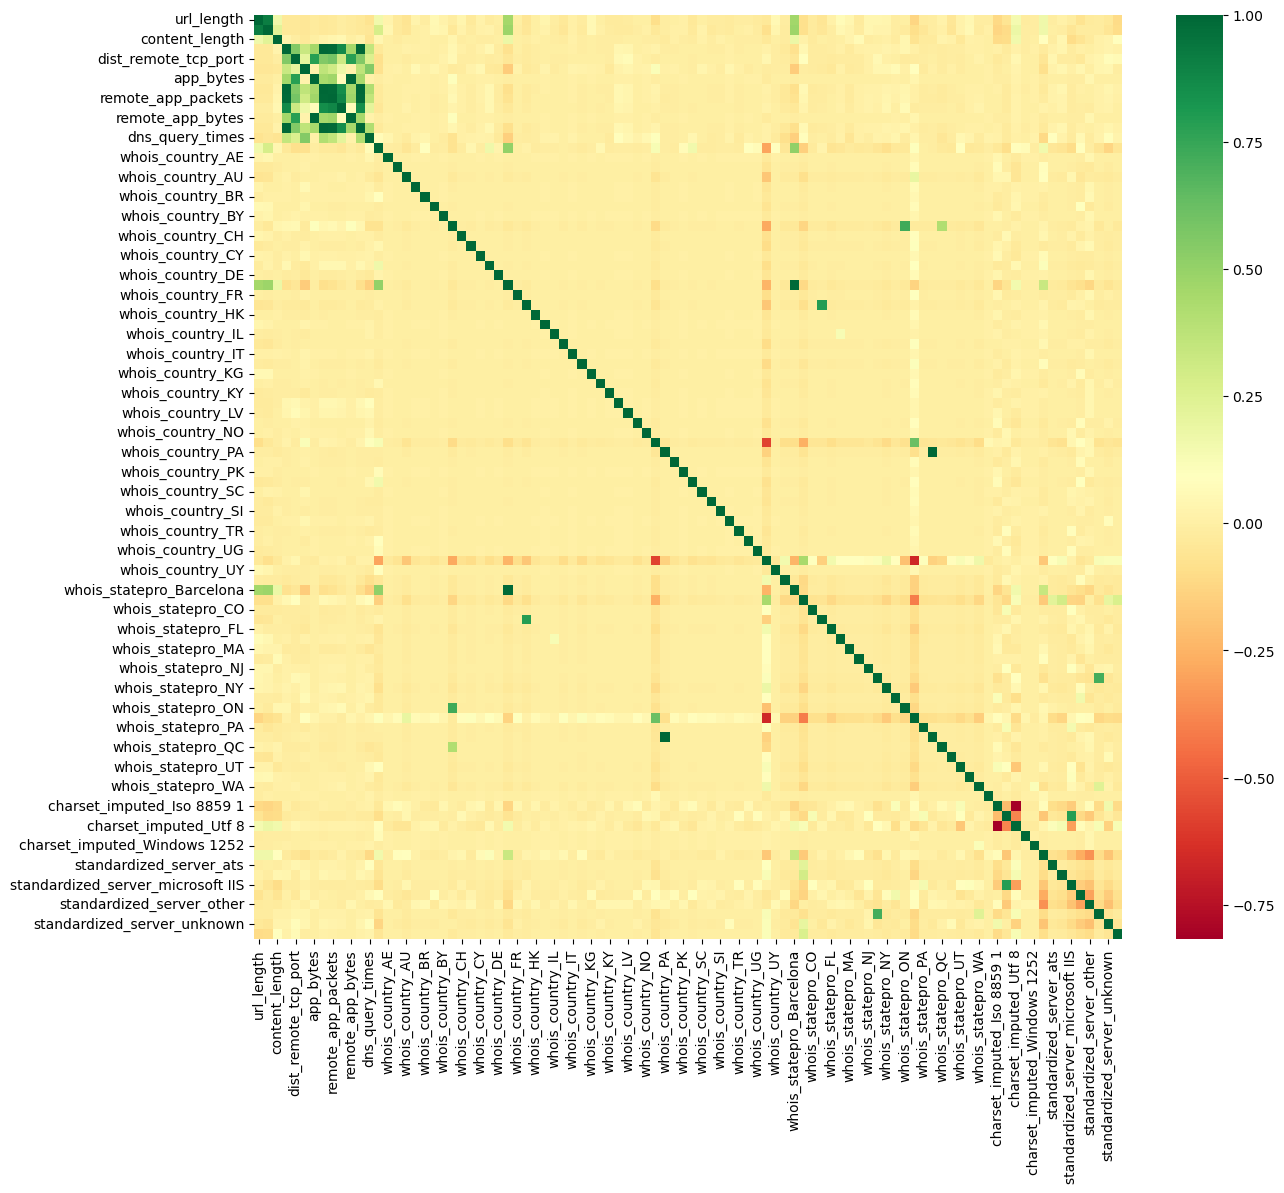

In [33]:
#Plot a heatmap of correlation of features.
heatmap_examine = preprocess_df

plt.figure(figsize=(14, 12))


sns.heatmap(heatmap_examine.corr(), annot=False, cmap="RdYlGn");

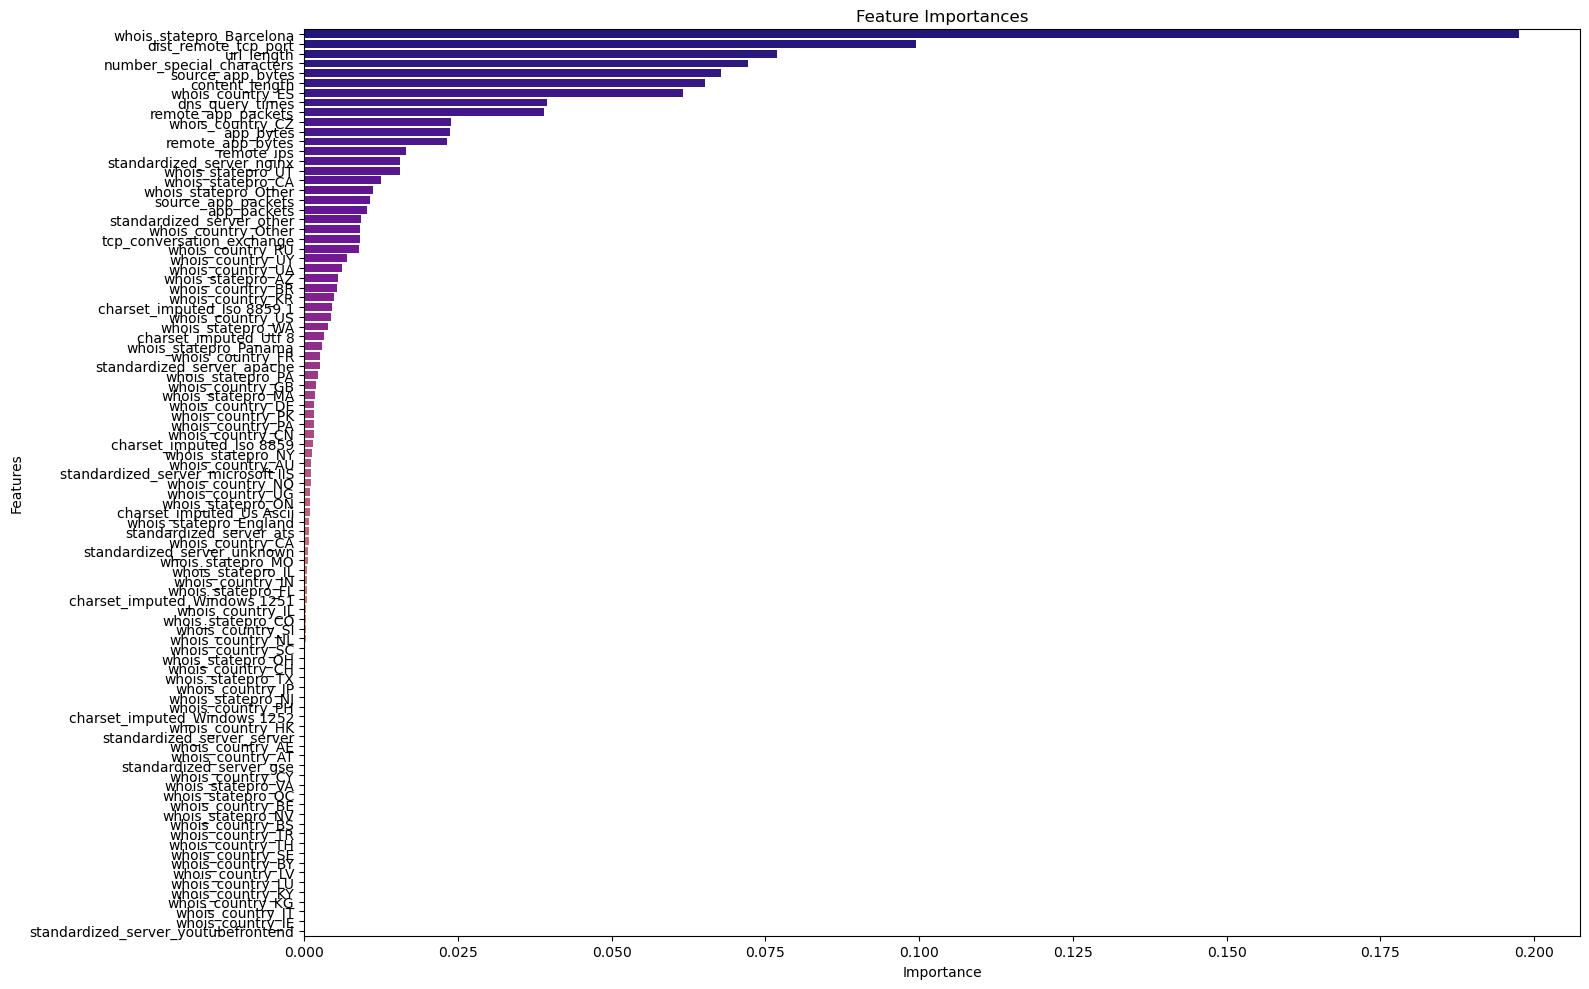

In [34]:
# Use random forest to evaluate feature importance of the dataframe.
model = RandomForestRegressor()
model.fit(preprocess_df.drop(columns=['type']), preprocess_df['type'])

feature_importances = pd.DataFrame(model.feature_importances_,
                                   index=preprocess_df.drop(columns=['type']).columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
# print(feature_importances[:25])

# Plot the feature importances
plt.figure(figsize=(16, 10))
sns.barplot(x=feature_importances['importance'], y=feature_importances.index, palette="plasma")
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [35]:
#Getting the top 15 features with the most signal and appending it to new variable top_15_df. Also adding in the target column
top_15_features = feature_importances.head(15).index.tolist()
top_15_df = preprocess_df[top_15_features + ['type']]

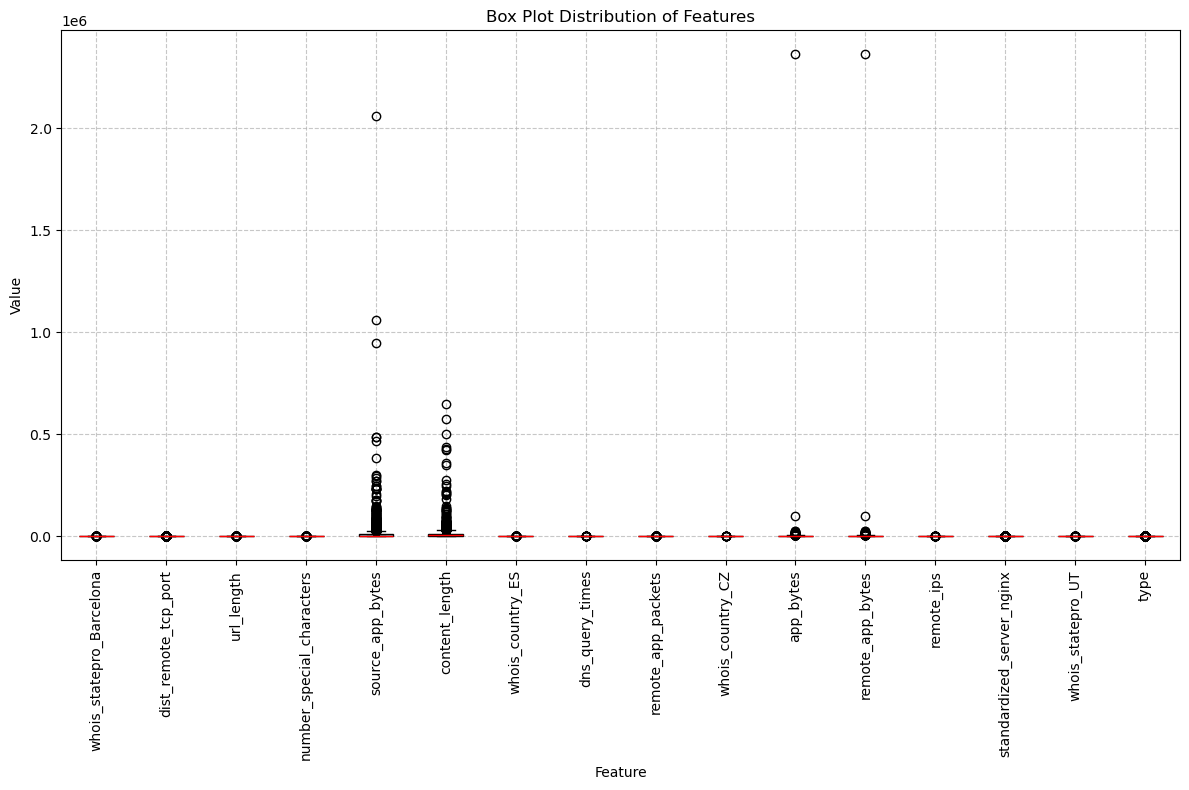

In [36]:
#Inspecting a distribution of variables of my data via a boxplot to inspect the outliers. Few outliers.

plt.figure(figsize=(12, 8))  
top_15_df.boxplot(grid=True, rot=90, patch_artist=True, 
                  boxprops=dict(facecolor='lightblue', color='black'),
                  whiskerprops=dict(color='black'),
                  capprops=dict(color='black'),
                  medianprops=dict(color='red'))

# Customize the plot
plt.title('Box Plot Distribution of Features')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.grid(True, linestyle='--', alpha=0.7) 
plt.tight_layout()  

# Show the plot
plt.show()

In [37]:
#Going to create a function for "Shotgun approach" for machine learning modeling.

def classification_model_test(model, X_train, y_train, X_test, y_test):
    # Fit the model with the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate and return the accuracy score
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

    # Generate heatmap of confusion matrix
    sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred),
            annot=True,
            cmap="coolwarm",
            square=True)

    # Print classification report
    print(classification_report(y_true=y_test, y_pred=y_pred))

    return f"Accuracy Score: {accuracy:.2f}"

In [38]:
#Create my target and split the data into X and y to set it up for train test split.
TARGET = ['type']

X, y = top_15_df.drop(columns=TARGET, axis=1), top_15_df[TARGET]

In [39]:
#Setting up training and test data splits for machine learning.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )


              precision    recall  f1-score   support

           0       0.86      1.00      0.92       306
           1       0.00      0.00      0.00        51

    accuracy                           0.86       357
   macro avg       0.43      0.50      0.46       357
weighted avg       0.73      0.86      0.79       357



'Accuracy Score: 0.86'

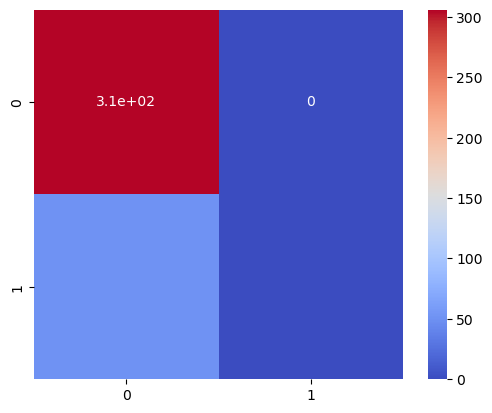

In [40]:
log_reg = LogisticRegression()
classification_model_test(log_reg, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       306
           1       0.50      0.31      0.39        51

    accuracy                           0.86       357
   macro avg       0.70      0.63      0.65       357
weighted avg       0.84      0.86      0.84       357



'Accuracy Score: 0.86'

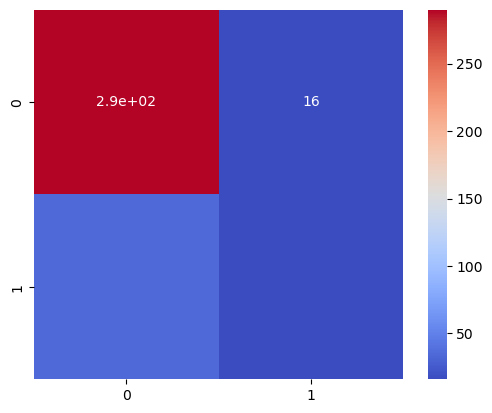

In [41]:
knn_model = KNeighborsClassifier()
classification_model_test(knn_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       306
           1       0.86      0.71      0.77        51

    accuracy                           0.94       357
   macro avg       0.90      0.84      0.87       357
weighted avg       0.94      0.94      0.94       357



'Accuracy Score: 0.94'

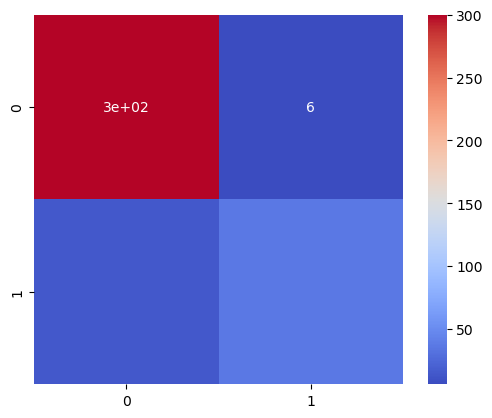

In [42]:
dtc_model = DecisionTreeClassifier()
classification_model_test(dtc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       306
           1       0.00      0.00      0.00        51

    accuracy                           0.85       357
   macro avg       0.43      0.50      0.46       357
weighted avg       0.73      0.85      0.79       357



'Accuracy Score: 0.85'

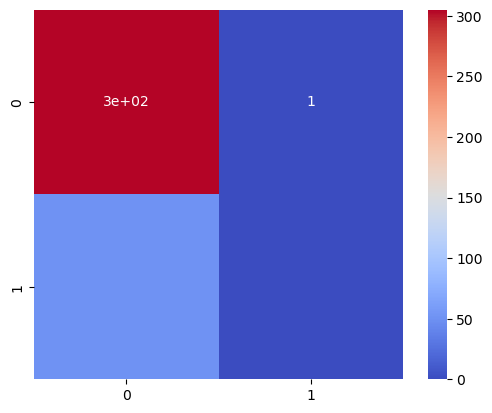

In [43]:
svc_model = SVC()
classification_model_test(svc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       306
           1       0.95      0.75      0.84        51

    accuracy                           0.96       357
   macro avg       0.95      0.87      0.91       357
weighted avg       0.96      0.96      0.96       357



'Accuracy Score: 0.96'

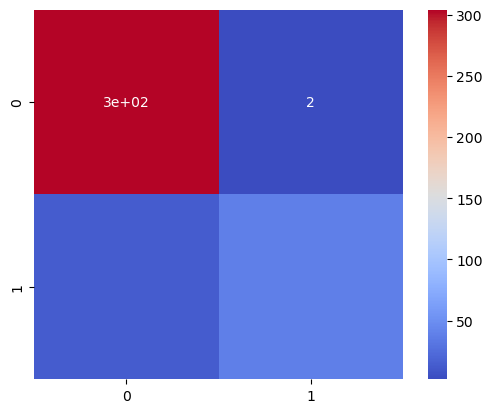

In [44]:
gbc_model = GradientBoostingClassifier()
classification_model_test(gbc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       306
           1       0.93      0.73      0.81        51

    accuracy                           0.95       357
   macro avg       0.94      0.86      0.89       357
weighted avg       0.95      0.95      0.95       357



'Accuracy Score: 0.95'

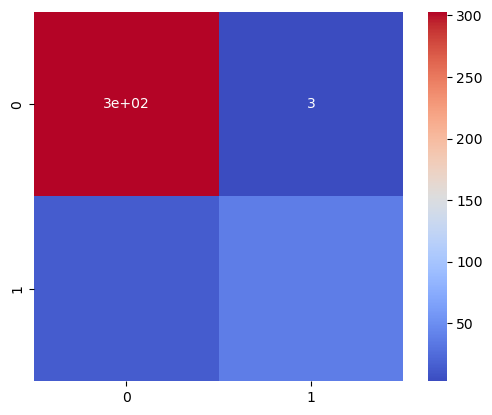

In [45]:
ada_model = AdaBoostClassifier()
classification_model_test(ada_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       306
           1       0.92      0.69      0.79        51

    accuracy                           0.95       357
   macro avg       0.94      0.84      0.88       357
weighted avg       0.95      0.95      0.94       357



'Accuracy Score: 0.95'

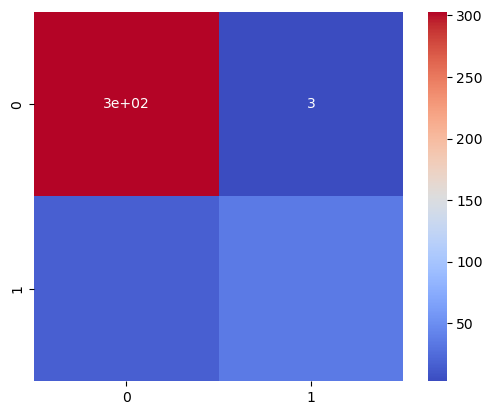

In [46]:
rfc_model = RandomForestClassifier()
classification_model_test(rfc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       306
           1       0.95      0.69      0.80        51

    accuracy                           0.95       357
   macro avg       0.95      0.84      0.88       357
weighted avg       0.95      0.95      0.95       357



'Accuracy Score: 0.95'

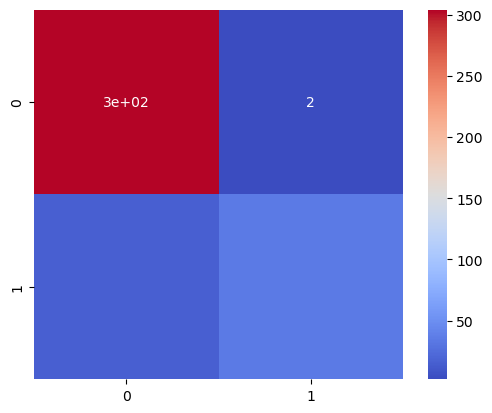

In [47]:
sgd_model = SGDClassifier()
classification_model_test(rfc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.82      0.42      0.55       306
           1       0.11      0.45      0.18        51

    accuracy                           0.42       357
   macro avg       0.47      0.43      0.37       357
weighted avg       0.72      0.42      0.50       357



'Accuracy Score: 0.42'

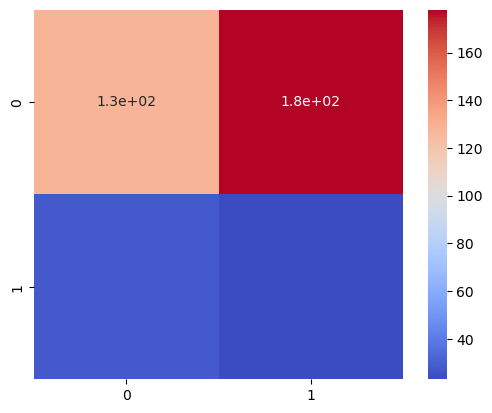

In [48]:
mnb_model = MultinomialNB()
classification_model_test(mnb_model, X_train, y_train, X_test, y_test)

### **Takeaways**

I used 9 different classifiers for machine learning and the best performing models were Gradient Boosting Classifier at 96% accuracy,Random Forest and SGD classifier at 95% accuracy. The worst performing model was the multinomial nieve bayes with a 42% accuracy score. Therefore after analysing and collecting my results, I will move forward with hyper parameter tuning for the random forest classifier and SGD classifier.

In [49]:
#Setup cross-validation for hyper parameter tuning and grids for hyperparameter tuning for the models I will be focusing on.

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

#Create exhaustive grid search for SGD Model.
grid_sgd = dict()

grid_sgd["penalty"] = ["l2", "l1", "elasticnet"]
grid_sgd["alpha"] = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
grid_sgd["max_iter"] = [100, 200, 300, 400, 500]
grid_sgd["learning_rate"] = ["constant", "optimal", "invscaling", "adaptive"]
grid_sgd["eta0"] = [0.01, 0.1, 1]
grid_sgd["class_weight"] = [None, 'balanced']
grid_sgd['average'] = [False, True]

#Create exhaustive grid search for Random Forest Model.
grid_rfc = dict()

grid_rfc['n_estimators'] = [10, 50, 100, 200, 300]
grid_rfc['min_samples_split'] = [2, 5, 10]
grid_rfc['max_depth'] = [None, 10, 20, 30, 40]
grid_rfc['min_samples_leaf'] = [1, 2, 4]

# Create exhaustive grid search for Gradient Boosting Classifier.
grid_gbc = dict()

grid_gbc['n_estimators'] = [10, 50, 100, 200, 300]          
grid_gbc['learning_rate'] = [0.01, 0.1, 0.05]               
grid_gbc['max_depth'] = [3, 4, 5]                          
grid_gbc['min_samples_split'] = [2, 5, 10]                  
grid_gbc['min_samples_leaf'] = [1, 2, 4]                    

### **Stochastic Gradient Descent (SGD) Model**

In [50]:
#Adjust search for the SGD model
search = GridSearchCV(estimator=sgd_model,
                      param_grid=grid_sgd,
                      cv=cv,
                      scoring='accuracy',
                      n_jobs=-1                            
                      )

In [51]:
#Create result variable to fit the search gridsearch with x train and y train data.
result = search.fit(X_train, y_train)

In [52]:
#Print best score and optimal parameters.
print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

> BEST SCORE: 		0.8857693949243244
> OPTIMAL PARAMETERS: 	{'alpha': 100, 'average': False, 'class_weight': None, 'eta0': 0.1, 'learning_rate': 'invscaling', 'max_iter': 100, 'penalty': 'l1'}


### **Random Forest Model**

In [53]:
#Adjust search for the RFC model
search_rfc = GridSearchCV(estimator=rfc_model,
                      param_grid=grid_rfc,
                      cv=cv,
                      scoring='accuracy',
                      n_jobs=-1                            
                      )

In [54]:
#Create result variable to fit the search gridsearch with x train and y train data.
result = search_rfc.fit(X_train, y_train)

In [55]:
#Print best score and optimal parameters.
print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

> BEST SCORE: 		0.9648905085524804
> OPTIMAL PARAMETERS: 	{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### **Gradient Boosting Classifier Model**

In [56]:
#Adjust search for the RFC model
search = GridSearchCV(estimator=gbc_model,
                      param_grid=grid_gbc,
                      cv=cv,
                      scoring='accuracy',
                      n_jobs=-1                            
                      )

In [57]:
#Create result variable to fit the search gridsearch with x train and y train data.
result = search.fit(X_train, y_train)

In [58]:
#Print best score and optimal parameters.
print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

> BEST SCORE: 		0.9705111789618832
> OPTIMAL PARAMETERS: 	{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


The Gradient Boosing Classifier Model proves to be the best with a score of 97% accuracy! That is great. Let's try to see if we can improve that and use a SMOTE technique to balance the classes a bit more.

In [59]:
# Use the best estimator from the grid search to make predictions on the test data
best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy Score: {:.2f}%".format(accuracy * 100))

# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)



Confusion Matrix:
[[303   3]
 [ 13  38]]

Accuracy Score: 95.52%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       306
           1       0.93      0.75      0.83        51

    accuracy                           0.96       357
   macro avg       0.94      0.87      0.90       357
weighted avg       0.95      0.96      0.95       357



<Figure size 800x600 with 0 Axes>

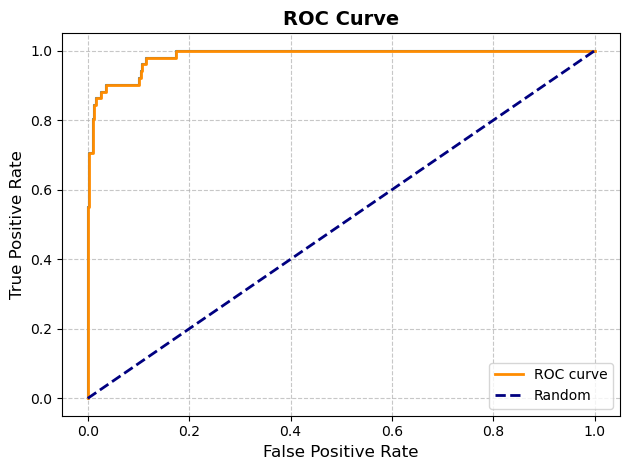

In [61]:
# Get the predicted probabilities for the positive class
y_pred_proba = best_model.predict_proba(X_test)[:, 1] 

# Generate the ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))  # Set the figure size
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# Customize the plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')  # Line color and width
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')  # Diagonal line
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')  # Position of the legend
plt.grid(True, linestyle='--', alpha=0.7)  # Grid style
plt.tight_layout()  # Adjust layout to fit labels

# Show the plot
plt.show()

### Of the three best performers, the gradient booster classifier performed the best. There is an imbalance in the classes. The recall for actual positives that were classified by the model is lower than I would like it to be. Therefore, I will try to balance the classes by applying SMOTE to my data to balance the classes.

### **SMOTE balanced Grandient Boost Classifier Testing**

In [62]:
sm = SMOTE(random_state=42)

X_resampled, y_resampled = sm.fit_resample(X, y)

print(f"Original X shape: {X.shape}")
print(f"Resampled X shape: {X_resampled.shape}")
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.8, test_size=0.2, random_state=42)
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Original X shape: (1781, 15)
Resampled X shape: (3130, 15)
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       323
           1       0.96      0.97      0.97       303

    accuracy                           0.97       626
   macro avg       0.97      0.97      0.97       626
weighted avg       0.97      0.97      0.97       626

[[312  11]
 [  8 295]]
Accuracy: 0.9696485623003195


In [63]:
#Create result variable to fit the search gridsearch with x train and y train data applied SMOTE data.
result = search.fit(X_train, y_train)

In [64]:
#Get new results with SMOTE applied testing data and hyper parameter tuned model. 97.4%! Slight increase.
print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

> BEST SCORE: 		0.9748377158034527
> OPTIMAL PARAMETERS: 	{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}


In [65]:
# Use the best estimator from the grid search to make predictions on the test data
best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy Score: {:.2f}%".format(accuracy * 100))

# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[318   5]
 [  5 298]]

Accuracy Score: 98.40%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       323
           1       0.98      0.98      0.98       303

    accuracy                           0.98       626
   macro avg       0.98      0.98      0.98       626
weighted avg       0.98      0.98      0.98       626



<Figure size 800x600 with 0 Axes>

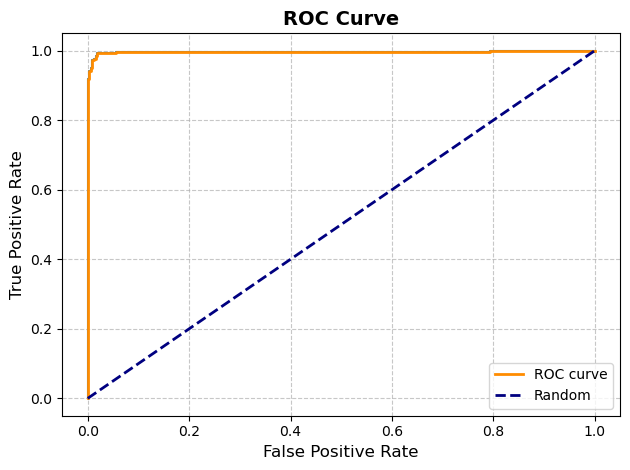

In [66]:
# Get the predicted probabilities for the positive class
y_pred_proba = best_model.predict_proba(X_test)[:, 1] 

# Generate the ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))  # Set the figure size
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# Customize the plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')  # Line color and width
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')  # Diagonal line
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')  # Position of the legend
plt.grid(True, linestyle='--', alpha=0.7)  # Grid style
plt.tight_layout()  # Adjust layout to fit labels

# Show the plot
plt.show()

### **Outcome**

After applying SMOTE, my accuracy improved even further, to 98.40% on testing and prediction data! That is great progress to improving the model with the Gradient Boosting Classifier.

Lets look into Random Forest with SMOTE transformed data.

### **SMOTE balanced Random Forest Classifier Testing**

In [67]:
#Create result variable to fit the search gridsearch with x train and y train data applied SMOTE data.
result_random_forest = search_rfc.fit(X_train, y_train)

In [68]:
#Get new results with SMOTE applied testing data and hyper parameter tuned model. 97.4%! Slight increase.
print("> BEST SCORE: \t\t{}".format(result_random_forest.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result_random_forest.best_params_))

> BEST SCORE: 		0.9729758300132804
> OPTIMAL PARAMETERS: 	{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [69]:
# Use the best estimator from the grid search to make predictions on the test data
best_model_rfc = result_random_forest.best_estimator_
y_pred_rf = best_model_rfc.predict(X_test)

# Generate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_rf)

# Calculate the accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("\nAccuracy Score: {:.2f}%".format(accuracy_rf * 100))

# Generate the classification report
class_report_rf = classification_report(y_test, y_pred_rf)
print("\nClassification Report:")
print(class_report_rf)

Confusion Matrix:
[[318   5]
 [  5 298]]

Accuracy Score: 98.08%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       323
           1       0.99      0.97      0.98       303

    accuracy                           0.98       626
   macro avg       0.98      0.98      0.98       626
weighted avg       0.98      0.98      0.98       626



<Figure size 800x600 with 0 Axes>

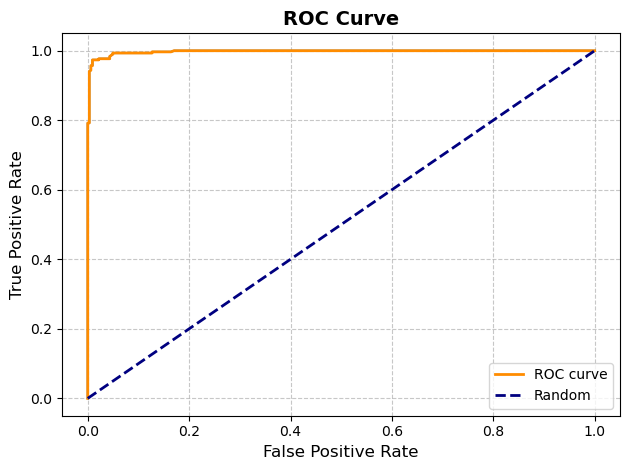

In [70]:
# Get the predicted probabilities for the positive class
y_pred_proba_rfc = best_model_rfc.predict_proba(X_test)[:, 1] 

# Generate the ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rfc)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))  # Set the figure size
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# Customize the plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')  # Line color and width
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')  # Diagonal line
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')  # Position of the legend
plt.grid(True, linestyle='--', alpha=0.7)  # Grid style
plt.tight_layout()  # Adjust layout to fit labels

# Show the plot
plt.show()

### **Outcome**

After applying SMOTE, my accuracy improved even further, to 98.08% on testing and prediction data! That is great progress to improving the model with the Random Forest Classifier.

Despite running these two classifiers on my newly resampled SMOTE training data,the Gradient Boost Classifier performed slighly better than the random forest model, by 0.3%! It's not a huge increase, but it is an increase.

Let's try to improve if possible by applying a pipeline and scaling our data.

### **Scaling and Gradient Boost Classifier**

In [71]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with SMOTE, StandardScaler, and a classifier
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  
    ('scaler', StandardScaler()),  
    ('classifier', GradientBoostingClassifier(random_state=42)) 
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy Score: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 93.84%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       306
           1       0.75      0.86      0.80        51

    accuracy                           0.94       357
   macro avg       0.86      0.91      0.88       357
weighted avg       0.94      0.94      0.94       357



### **Outcome**

After applying a pipeline to apply SMOTE and scale the data, my base accuracy actually decreased, to 93.84% with Gradient Boosting Classifier. I don't think it is worth moving forward with this attempt, as it is performing even worse right off the bat when compared to my other attempts.

In [72]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with SMOTE, StandardScaler, and a classifier
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  
    ('scaler', StandardScaler()),  
    ('classifier', RandomForestClassifier(random_state=42)) 
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy Score: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 94.96%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       306
           1       0.85      0.78      0.82        51

    accuracy                           0.95       357
   macro avg       0.91      0.88      0.89       357
weighted avg       0.95      0.95      0.95       357



### **Outcome**

After applying a pipeline to apply SMOTE and scale the data, my base accuracy actually decreased, to 95% with Random Forest Classifier, as oppose to 96% earlier. I don't think it is worth moving forward with this attempt, as it is performing even worse right off the bat when compared to my other attempts.

# Analysis

This has been an interesting analysis to see what will perform better when trying to train a model to predict for malicious websites, based on a number of features. First, I imported my data from my Exploratory data analysis notebook and imported all the data cleaning techniques I had previously used since my data was extremely messy. Next, I did some preprocessing techniques and dropped some columns from my dataframe that would not yield any meaningful results to the analysis and only confuse the machine learning models. I one-hot encoded my categorical features to make it easy for my models to interpret the data. At first glance I thought I was going to be inflicted by the "curse of dimensionality", as I had 96 features after one hot encoding. But I knew that many of the newly added features may not have any meaningful signal for predicting a malicious website. So I did a feature importance analysis to only use the top 15 features with the most signal for my analysis. 

The next step in my process was to try a "shotgun" approach of classification models to train them and see if I can pull any meaningful accuracy scores. I selected 9 models to test and too my surprise, many of them scored very well. The top 3 best performing models were the Gradient Boost Classifier with a 96 percent accuracy score, the Random Forest Classifier with a 96 percent accuracy score, and the Stochastic Gradient Descent(SGD) classifier with a 95 percent accuracy score. The worst performing model I selected was the Multinomial Naive Bayes Model with an accuracy score of 42 percent. Knowing this, I moved forward with hyperparameter tuning for these three machine learning models. I crafted three separate grids for hyperparameter tuning with carefully selected parameters to test the data for my three best performing machine learning models I mentioned earlier. Additionally, I used cross validation by incorporating repeated kfolds, with 10 splits.

With an exhaustive grid search set up, I first ran my test on the SGD model. To my surprise, this regressed in performance after hyperparameter tuning to 88%. Perhaps with the new parameters, it performed even worse due to the stochastic nature of the data. I decided it was best to not pursure this model after seeing the unpromising results. Next, I did an exhaustive grid search on the Random Forest model, which progressed in performance to 96.4 percent! This is a very minor increase, but it is still an increase. The final test I performed was on my Gradient Booster model, which also progressed in performance and performed the best, at 97.02 percent! I gained an entire percentage point in performance with the training data which is fantastic! I ran a prediction on y_test and compared to y_predict, and the model scored 95.52 percent accuracy which is very good. However, there still seemed to be an issue. After examining the confusion matrix and classification report, I had a lower than expected recall and f1 score for malicious websites. The support reveals that there is a substantial imbalance and the model may be overfit to benign websites. Therefore, I applied SMOTE to my data to rebalance the data and try again.

I applied SMOTE to my data for Gradient Boost Classifer at first. The support was better balanced, with roughly 300 per each class, as oppose to 300 for benign and 50 for malicious before. After applying the tuned model, it scored 97.4 percent on the training data, an even further increase than before. I then took the best estimator, applied it to test data and made predictions. The model scored a 98.4 percent accuracy score with a 98 percent precision, recall, and f1 score for all classes with SMOTE applied! The ROC curve revealed fantastic performance. I also applied this to the Random Forest model. It scored a 97.3 percent accuracy score on the training data, and a 98.03 percent on the prediction test. It still performed very well, but the Gradient Boost classifier performed slightly better overall. The precision was 1 percent better than the GBC model but the recall was 1 percent worse at 97 when compared to the GBC model. Overall both had an f1 score of 98, which is very good overall weighted average between precision and recall.

I also attempted to apply a pipeline to apply smote, then use standard scaler on some features that had outliers. However after performing my tests, it yielded results worse than what I had previously had, and deemed that it may not be appropriate to apply those techniques here in this case.

Overall, the model predicts with 98.4% accuracy and I am happy that it can identify malicious websites with a successful rate. Additional ways to improve the model may be to use even more features than the 15 that I had originally used, or by applying PCA to try to capture a large portion of the signal (perhaps up to 95% by calling it in the PCA argument) to retain a majority of the sigal in the principal components that get generated, despite one of the down sides of PCA, which is losing some data as a cost. XGBoost maye also potentially improve the models performance. It may be note worthy to to explore additional scaling, perhaps robust scaling. 

This is a very practical real world model that can be implemented or deployed by anyone or any organization. The ever existing and evolving threat of malicious activity over the world wide web is a constant threat everyday and it is imperative to protect yourself or your organization from spyware, malware, ransomeware, trojan horses, and much much more that can be contracted from visiting a malicious website. These malicious website can lock up your entire infrastructure for your business or personal computer and demand a payment to unlock it, which is commonly known as ransomeware. Additionally, malicious websites can download malware to your computer without your knowledge or permission, which can be designed to steal banking information, key loggers to steal credentials, DDoS malware, spam you with advertisingments, completely take control of your computer, and much more. I am excited to deploy this model and see it work in the real world!